In [1]:
#Імпортуємо модулі
from tensorflow.keras.datasets import fashion_mnist
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import utils
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from tensorflow.keras import utils

from keras.applications.vgg16 import VGG16
conv_base = VGG16 (weights = "imagenet", include_top = False, input_shape = (150, 150, 3))

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("x_train original shape:", x_train.shape)
print("y_train original shape:", y_train.shape)

x_train original shape: (60000, 28, 28)
y_train original shape: (60000,)


In [3]:
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

In [4]:
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = np.reshape(x_test, (-1, 28, 28, 1))

In [5]:
x_train = Concatenate()([x_train, x_train,x_train]) 
x_test = Concatenate() ([x_test, x_test, x_test])

x_train.shape

TensorShape([60000, 28, 28, 3])

In [6]:
resized_x_train = tf.image.resize(x_train, (32,32)) 
resized_x_test = tf.image.resize(x_test, (32,32))

resized_x_train. shape, x_train.shape

(TensorShape([60000, 32, 32, 3]), TensorShape([60000, 28, 28, 3]))

In [7]:
from tensorflow.keras.preprocessing.image import img_to_array

train_X = np.asarray([img_to_array(im) for im in resized_x_train])
test_X = np.asarray([img_to_array(im) for im in resized_x_test])

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_X,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=13)

In [9]:
train_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_generator = ImageDataGenerator(rescale = 1./255)

In [10]:
train_generator.fit(x_train)
test_generator.fit(x_val)

In [11]:
train_generator = train_generator.flow (x_train, y_train, batch_size = 200) 
test_generator = test_generator.flow (x_val,y_val, batch_size = 200)

In [12]:
x_test.shape

TensorShape([10000, 28, 28, 3])

In [13]:
conv_base = VGG16(weights = 'imagenet',
                 include_top = False,
                 input_shape = (150, 150, 3))

In [14]:
#conv_base.trainable = False
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1': 
        set_trainable = True
    if set_trainable: 
        layer.trainable = True
    else:
        layer.trainable = False

In [15]:
original_dim = (32, 32, 3)
target_size = (150, 150)

model = models.Sequential()
model.add(layers.Input(original_dim))
model.add(layers.Lambda(lambda image: tf.image.resize(image, target_size)))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 10)                1

In [17]:
checkpointer = ModelCheckpoint(filepath = "best_weights.hdf5", verbose = 1, save_best_only=True)
model.compile(loss = "categorical_crossentropy",
             optimizer = keras.optimizers.RMSprop(1e-4),
             metrics = ["accuracy"])
history = model.fit(train_generator,
              epochs = 10,
              steps_per_epoch = 20,
              validation_data = test_generator,
              validation_steps = 30,
              shuffle = True,
              callbacks = [checkpointer])

Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 2.0293 - accuracy: 0.2720 
Epoch 1: val_loss improved from inf to 1.28987, saving model to best_weights.hdf5
20/20 [==============================] - 506s 26s/step - loss: 2.0293 - accuracy: 0.2720 - val_loss: 1.2899 - val_accuracy: 0.5162
Epoch 2/10
20/20 [==============================] - ETA: 0s - loss: 1.1666 - accuracy: 0.5815 
Epoch 2: val_loss improved from 1.28987 to 0.77042, saving model to best_weights.hdf5
20/20 [==============================] - 505s 26s/step - loss: 1.1666 - accuracy: 0.5815 - val_loss: 0.7704 - val_accuracy: 0.6908
Epoch 3/10
20/20 [==============================] - ETA: 0s - loss: 0.8808 - accuracy: 0.6750 
Epoch 3: val_loss improved from 0.77042 to 0.56152, saving model to best_weights.hdf5
20/20 [==============================] - 505s 26s/step - loss: 0.8808 - accuracy: 0.6750 - val_loss: 0.5615 - val_accuracy: 0.7928
Epoch 4/10
20/20 [==============================] - ETA: 0s - loss: 

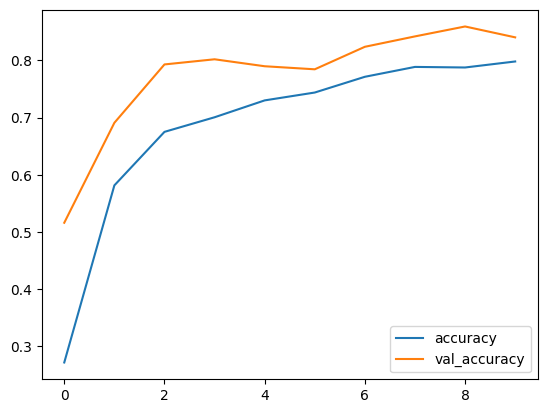

In [18]:
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.legend()

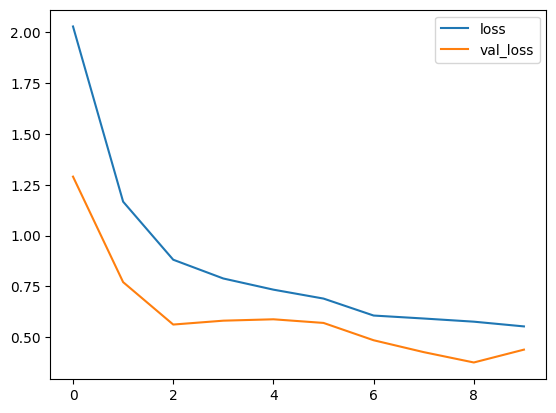

In [19]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()

In [20]:
x_test = tf.image.resize(x_test, (150, 150))

In [21]:
model = keras.models.load_model("best_weights.hdf5")

In [22]:
test_generator = ImageDataGenerator(
    rescale = 1./255
)

test_generator = test_generator.flow(
    x_test,
    y_test,
    batch_size=200
)

test_loss, test_acc = model.evaluate(test_generator, steps = 10)
print("test acc:", test_acc)

10/10 [==============================] - 56s 6s/step - loss: 0.3988 - accuracy: 0.8590
test acc: 0.859000027179718


<H4>Висновок: Модель досягла точності валідації 85.90% після навчання протягом 10 епох з часом навчання 86 хвилин. Для покращення точності моделі необхідно збільшити кількість кроків і епох, але це займе набагато більше часу для тренування моделі, і результат не гарантовано буде набагато кращим.
Порівнюючи з попередньою роботою, для цього датасету краще використовувати параметри з Практичного Завдання 4, оскільки часу затрачено на навчання мережі значно менше, а точність вища приблизно на 5%.<H4>